## Glidertest demo 

The purpose of this notebook is to demostrate the functionality of glidertests functions. 
This notebooks can be used to diagnose issues within your glider data. We have added suggested processing in some cases.

In [1]:
import sys

sys.path.append('/Users/eddifying/Cloudfree/gitlab-cloudfree/glidertest')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from glidertest import fetchers
from glidertest import tools

### Load dataset

Load an example dataset using `glidertest.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

In [3]:
ds2 = fetchers.load_sample_dataset()
ds = xr.open_dataset('../data/86910.nc')

In [4]:
ds


<xarray.Dataset> Size: 293MB
Dimensions:                  (sg_data_point: 2285344)
Coordinates:
    longitude                (sg_data_point) float64 18MB ...
    latitude                 (sg_data_point) float64 18MB ...
    depth                    (sg_data_point) float64 18MB ...
    time                     (sg_data_point) datetime64[ns] 18MB ...
Dimensions without coordinates: sg_data_point
Data variables:
    ctd_time                 (sg_data_point) datetime64[ns] 18MB ...
    salinity_qc              (sg_data_point) int64 18MB ...
    pressure                 (sg_data_point) float64 18MB ...
    salinity                 (sg_data_point) float64 18MB ...
    temperature_qc           (sg_data_point) int64 18MB ...
    temperature              (sg_data_point) float64 18MB ...
    dives                    (sg_data_point) float64 18MB ...
    temperature_adjusted     (sg_data_point) float64 18MB ...
    temperature_adjusted_qc  (sg_data_point) int64 18MB ...
    salinity_adjusted        (sg_data_point) float64 18MB ...
    salinity_adjusted_qc     (sg_data_point) int64 18MB ...
    density_adjusted         (sg_data_point) float64 18MB ...
Attributes: (12/31)
    date_created:             2021-07-29 11:33:00
    number_of_dives:          979.0
    files:                    
    time_coverage_start:      2019-12-05 11:53:56
    time_coverage_end:        2020-05-06 15:00:46
    geospatial_vertical_min:  -0.0688561662293005
    ...                       ...
    processing_level:         Processed data with initial QC with Basestation...
    area:                     Labrador Sea
    title:                    Glider deployment delayed time processed data
    transmission_system:      Iridium
    deployment_ship_name:     Adolf Jensen
    doi:

In [9]:
# Create a dictionary to map old variable names to new variable names
rename_dict = {
    'time': 'TIME',
    'latitude': 'LATITUDE',
    'longitude': 'LONGITUDE',
    'depth': 'DEPTH',
    'salinity': 'PSAL',
    'temperature': 'TEMP',
    'salinity_adjusted': 'PSAL_QC',
    'temperature_adjusted': 'TEMP_QC',
    'density_adjusted': 'DENSITY_QC'
}

# Rename the variables in ds
ds = ds.rename(rename_dict)

In [ ]:
ds2

## Basic stats for the glider

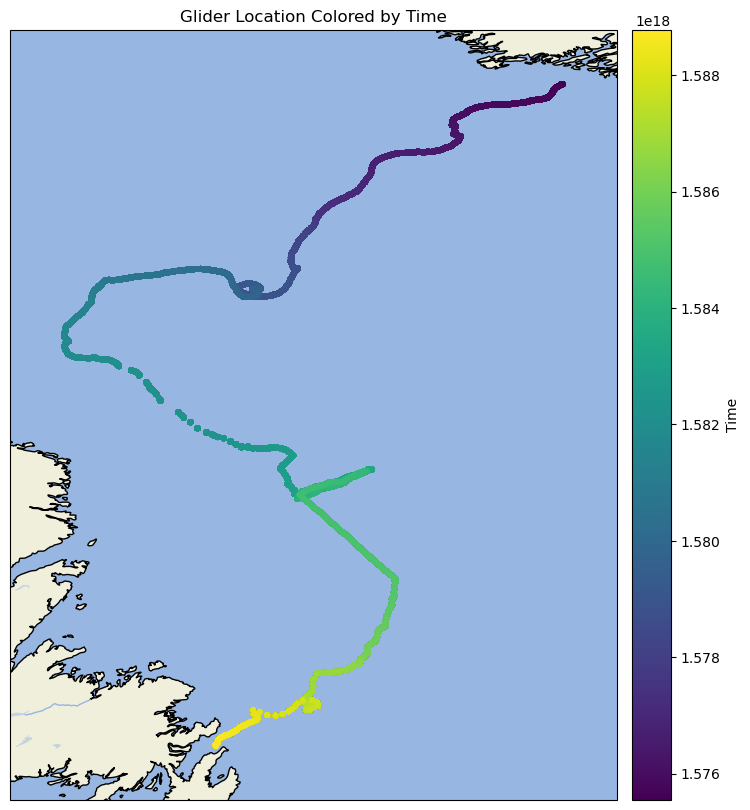

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Extract the necessary data
latitudes = ds['LATITUDE'].values
longitudes = ds['LONGITUDE'].values
times = ds['TIME'].values

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([np.min(longitudes)-1, np.max(longitudes)+1, np.min(latitudes)-1, np.max(latitudes)+1], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot the glider locations
sc = ax.scatter(longitudes, latitudes, c=times, cmap='viridis', s=10, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Time')

# Add title
ax.set_title('Glider Location Colored by Time')

plt.show()


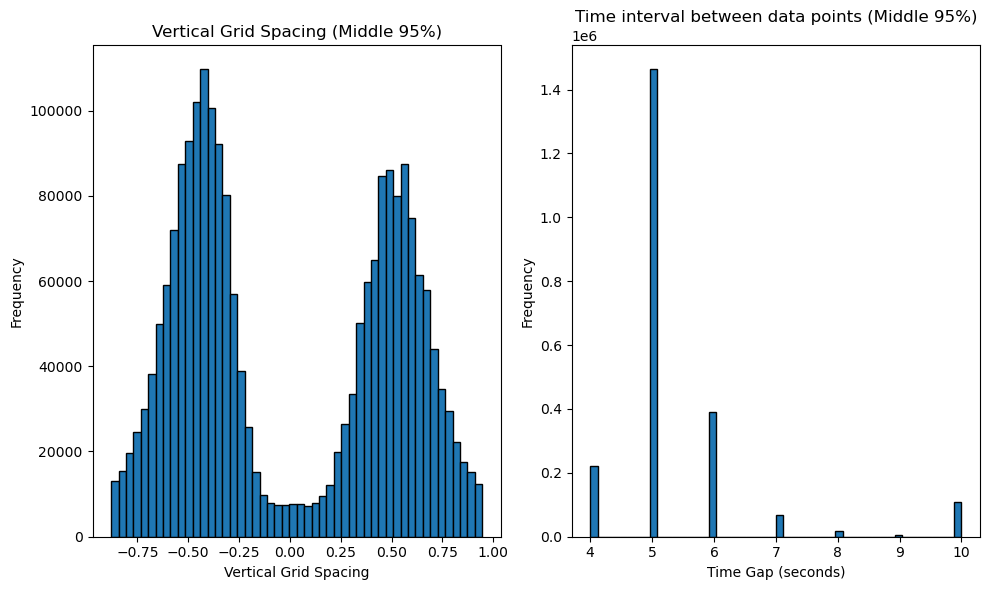

In [37]:
# Extract depth values from the dataset
depth_values = ds['DEPTH'].values

# Calculate the differences between consecutive depth values
vertical_grid_spacing = np.diff(depth_values)


# Calculate the 2.5th and 97.5th percentiles
lower_bound = np.percentile(vertical_grid_spacing, 2.5)
upper_bound = np.percentile(vertical_grid_spacing, 97.5)

# Filter the vertical_grid_spacing to include only the middle 95% of the points
filtered_spacing = vertical_grid_spacing[(vertical_grid_spacing >= lower_bound) & (vertical_grid_spacing <= upper_bound)]

# Calculate the time differences between consecutive time values
time_diffs = np.diff(times) / np.timedelta64(1, 's')  # Convert to seconds

# Calculate the 2.5th and 97.5th percentiles
lower_bound_time = np.percentile(time_diffs, .5)
upper_bound_time = np.percentile(time_diffs, 99.5)

# Filter the time differences to include only the middle 95% of the points
filtered_time_diffs = time_diffs[(time_diffs >= lower_bound_time) & (time_diffs <= upper_bound_time)]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Plot the histogram of vertical grid spacing
ax[0].hist(filtered_spacing, bins=50, edgecolor='black')
ax[0].set_title('Vertical Grid Spacing (Middle 95%)')
ax[0].set_xlabel('Vertical Grid Spacing')
ax[0].set_ylabel('Frequency')

# Plot the histogram of time intervals
ax[1].hist(filtered_time_diffs, bins=50, edgecolor='black')
ax[1].set_title('Time interval between data points (Middle 95%)')
ax[1].set_xlabel('Time Gap (seconds)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

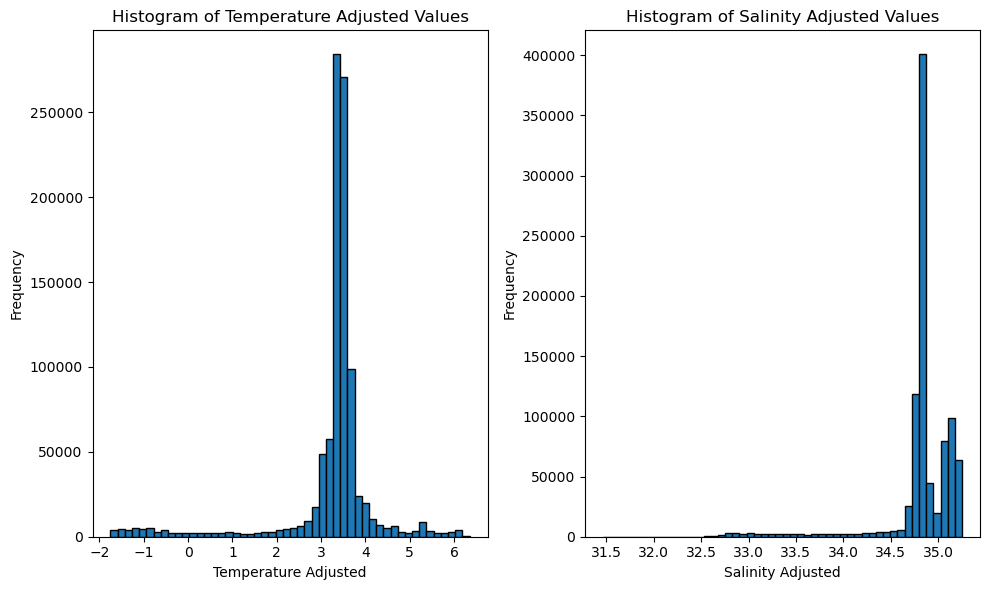

In [39]:
# Extract temperature adjusted values from the dataset
temperature_adjusted_values = ds['TEMP_QC'].values

# Extract salinity adjusted values from the dataset
salinity_adjusted_values = ds['PSAL_QC'].values

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# # Create the plot with two panelsfig, ax = plt.subplots(1, 2, figsize=(15, 6))# Plot the histogram of temperature adjusted values on the left panel
ax[0].hist(temperature_adjusted_values, bins=50, edgecolor='black')
ax[0].set_title('Histogram of Temperature Adjusted Values')
ax[0].set_xlabel('Temperature Adjusted')
ax[0].set_ylabel('Frequency')

# Plot the histogram of salinity adjusted values on the right panel
ax[1].hist(salinity_adjusted_values, bins=50, edgecolor='black')
ax[1].set_title('Histogram of Salinity Adjusted Values')
ax[1].set_xlabel('Salinity Adjusted')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

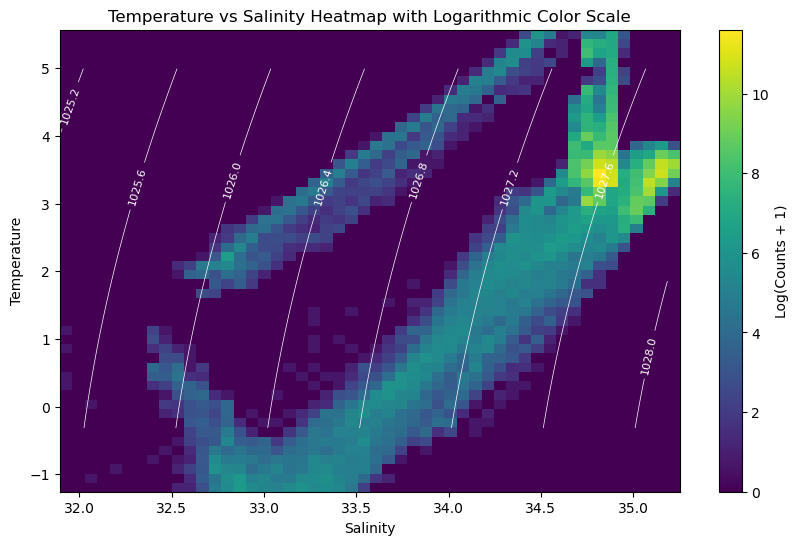

ValueError: 'cmocean.cm.matter' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cmo.algae', 'cmo.algae_i', 'cmo.algae_i_r', 'cmo.algae_r', 'cmo.algae_r_i', 'cmo.amp', 'cmo.amp_i', 'cmo.amp_i_r', 'cmo.amp_r', 'cmo.amp_r_i', 'cmo.balance', 'cmo.balance_i', 'cmo.balance_i_r', 'cmo.balance_r', 'cmo.balance_r_i', 'cmo.curl', 'cmo.curl_i', 'cmo.curl_i_r', 'cmo.curl_r', 'cmo.curl_r_i', 'cmo.deep', 'cmo.deep_i', 'cmo.deep_i_r', 'cmo.deep_r', 'cmo.deep_r_i', 'cmo.delta', 'cmo.delta_i', 'cmo.delta_i_r', 'cmo.delta_r', 'cmo.delta_r_i', 'cmo.dense', 'cmo.dense_i', 'cmo.dense_i_r', 'cmo.dense_r', 'cmo.dense_r_i', 'cmo.diff', 'cmo.diff_i', 'cmo.diff_i_r', 'cmo.diff_r', 'cmo.diff_r_i', 'cmo.gray', 'cmo.gray_i', 'cmo.gray_i_r', 'cmo.gray_r', 'cmo.gray_r_i', 'cmo.haline', 'cmo.haline_i', 'cmo.haline_i_r', 'cmo.haline_r', 'cmo.haline_r_i', 'cmo.ice', 'cmo.ice_i', 'cmo.ice_i_r', 'cmo.ice_r', 'cmo.ice_r_i', 'cmo.matter', 'cmo.matter_i', 'cmo.matter_i_r', 'cmo.matter_r', 'cmo.matter_r_i', 'cmo.oxy', 'cmo.oxy_i', 'cmo.oxy_i_r', 'cmo.oxy_r', 'cmo.oxy_r_i', 'cmo.phase', 'cmo.phase_i', 'cmo.phase_i_r', 'cmo.phase_r', 'cmo.phase_r_i', 'cmo.rain', 'cmo.rain_i', 'cmo.rain_i_r', 'cmo.rain_r', 'cmo.rain_r_i', 'cmo.solar', 'cmo.solar_i', 'cmo.solar_i_r', 'cmo.solar_r', 'cmo.solar_r_i', 'cmo.speed', 'cmo.speed_i', 'cmo.speed_i_r', 'cmo.speed_r', 'cmo.speed_r_i', 'cmo.tarn', 'cmo.tarn_i', 'cmo.tarn_i_r', 'cmo.tarn_r', 'cmo.tarn_r_i', 'cmo.tempo', 'cmo.tempo_i', 'cmo.tempo_i_r', 'cmo.tempo_r', 'cmo.tempo_r_i', 'cmo.thermal', 'cmo.thermal_i', 'cmo.thermal_i_r', 'cmo.thermal_r', 'cmo.thermal_r_i', 'cmo.topo', 'cmo.topo_i', 'cmo.topo_i_r', 'cmo.topo_r', 'cmo.topo_r_i', 'cmo.turbid', 'cmo.turbid_i', 'cmo.turbid_i_r', 'cmo.turbid_r', 'cmo.turbid_r_i', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

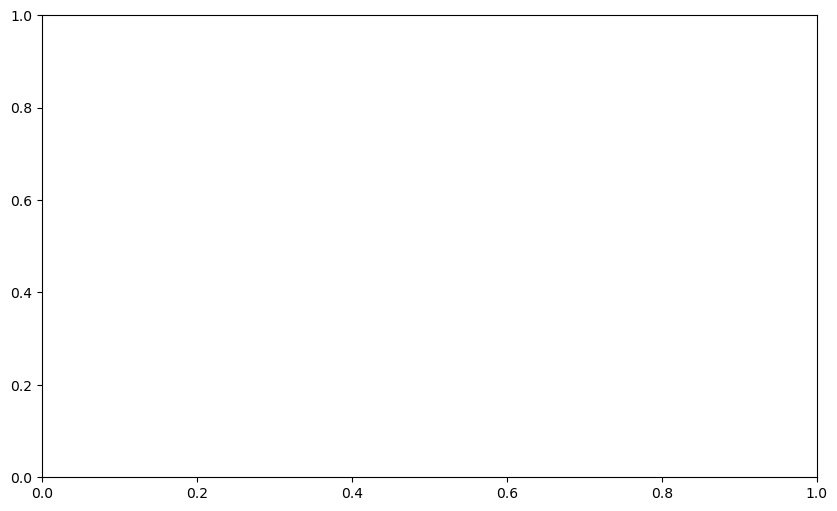

In [60]:
import gsw
import cmocean

# Remove NaN values from temperature_adjusted_values and salinity_adjusted_values
valid_indices = ~np.isnan(temperature_adjusted_values) & ~np.isnan(salinity_adjusted_values)
temperature_adjusted_values = temperature_adjusted_values[valid_indices]
salinity_adjusted_values = salinity_adjusted_values[valid_indices]

# Calculate the 2.5th and 97.5th percentiles for temperature adjusted values
lower_bound_temp = np.percentile(temperature_adjusted_values, 1)
upper_bound_temp = np.percentile(temperature_adjusted_values, 99)

# Filter the temperature adjusted values to include only the middle 95% of the points
filtered_temp_adjusted = temperature_adjusted_values[(temperature_adjusted_values >= lower_bound_temp) & (temperature_adjusted_values <= upper_bound_temp)]

# Subselect the corresponding salinity adjusted values for the same points
filtered_salinity_adjusted = salinity_adjusted_values[(temperature_adjusted_values >= lower_bound_temp) & (temperature_adjusted_values <= upper_bound_temp)]

# Compute density using the gsw toolbox
density_values = gsw.rho(filtered_salinity_adjusted, filtered_temp_adjusted, 0)  # Assuming pressure is 0 dbar

# Create a 2D histogram (heatmap) of temperature vs salinity
plt.figure(figsize=(10, 6))
heatmap, xedges, yedges = np.histogram2d(filtered_salinity_adjusted, filtered_temp_adjusted, bins=50)


# Plot the heatmap with a logarithmic color scale
plt.figure(figsize=(10, 6))
plt.imshow(np.log1p(heatmap.T), origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Log(Counts + 1)')
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('Temperature vs Salinity Heatmap with Logarithmic Color Scale')

# Add density contours
contours = plt.contour(salinity_grid, temperature_grid, density_grid, colors='white', linewidths=0.5)
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

plt.show()



In [51]:
print(upper_bound_temp)

nan


### Check basic data and water column structure first

In [ ]:
tools.plot_basic_vars(ds,v_res=1, start_prof=1, end_prof=int(ds.PROFILE_NUMBER.max()))

## Check if the profile number was assigned well 

We want to check if the profile number is consistently increasing or not.
When using pyglider to assign the profile, there can be some issues if the correct pressure and time threshold is not chosen.

Users, based on their dataset will chose a specific min_dp and profile_min_time for the get_profiles_new(). If not chosen carefully, the function may struggle assigning a profile number (resulting in 0s in the middle of the dataset) or could split profiles when, for example, the glider get stuck on pycnoclne


In [ ]:
tools.check_monotony(ds.PROFILE_NUMBER)
tools.plot_profIncrease(ds)

### Check for up-downcast bias in Salinity, Temperature, Chlorophyll and Oxygen

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

tools.plot_updown_bias(tools.updown_bias(ds, var='TEMP', v_res=1), ax[0],  xlabel='Temperature [C]')
tools.plot_updown_bias(tools.updown_bias(ds, var='PSAL', v_res=1), ax[1],  xlabel='Salinity [PSU]')
tools.plot_updown_bias(tools.updown_bias(ds, var='DOXY', v_res=1), ax[2],  xlabel='Dissolved Oxygen [mmol m-3]')
tools.plot_updown_bias(tools.updown_bias(ds, var='CHLA', v_res=1), ax[3],  xlabel='Chlorophyll [mg m-3]')

ax[0].set_ylabel('Depth [m]')

### CTD

Check for any thermal intertia related issues

Salinity SOP provides a great summary of the needed processing of salinity data and the vaious difference based on sensor modela nd platform type https://oceangliderscommunity.github.io/Salinity_SOP/sections/salinity_dmqc.html

### Chlorophyll fluorescence

*  Check bottom data and see if we have stable data that can be used for calibration. We also check stability of data to assess whether or not we have suspicious drift over the mission
* We check for any temporal drift when analysing the entire water column and not just the bottom data
* We then check if data is affected by non photochemical quenching (NPQ). NPQ is a physiological response to high light environments used by plants and algae to protect themselves from damage and causes an evident weakening in fluorescence signal during the day. With the 'day_night_avg' function, we compute day and night averages of chlorophyll. We then plot a selected section of chlorophyll data with 'plot_section_with_srss' to see if any NPQ effect in the top few meters is visible and then we plot a selcted day daily and night average to check again any NPQ effect with 'plot_daynight_avg'.

(Reminder this tests mission had issues with FLBBCD as it stopped working few days into the missiona and got flooded)

In [ ]:
tools.optics_first_check(ds, var='CHLA')

In [ ]:
tools.check_temporal_drift(ds, var='CHLA')

In [ ]:
# Let's visually check a section of chlorphyll and see if we observe any NPQ
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

tools.plot_section_with_srss(ds, 'CHLA', ax, start_time = '2023-09-06', end_time = '2023-09-10', ylim=35)

In [ ]:
# Compute day and night average for chlorophylla and temeparture
dayT, nightT = tools.day_night_avg(ds, sel_var='TEMP',start_time = '2023-09-06', end_time = '2023-09-10')
dayS, nightS = tools.day_night_avg(ds, sel_var='PSAL',start_time = '2023-09-06', end_time = '2023-09-10')
dayC, nightC = tools.day_night_avg(ds, sel_var='CHLA',start_time = '2023-09-06', end_time = '2023-09-10')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

tools.plot_daynight_avg( dayT, nightT, ax[0],sel_day='2023-09-08', xlabel='Temperature [C]')
tools.plot_daynight_avg( dayS, nightS, ax[1],sel_day='2023-09-08', xlabel='Salinity [PSU]')
tools.plot_daynight_avg( dayC, nightC, ax[2],sel_day='2023-09-08', xlabel='Chlorophyll [mg m-3]')

Do we see any difference in chl between day and night? Can this just simply be explained by changes in water mass properties (different temp and salinity)?

#### Non photochemical quenching corrections
NPQ occurs only during the daytime, therefore when night measurements close in time and 
space are available, they can be used to correct daytime profiles. Different methods exist for NPQ 
correction. We recommend the paper by Thomalla et al. (2018) for a good overview on all possible methods. 
GliderTools (https://glidertools.readthedocs.io/en/latest/optics.html#quenching-correction) provides good tools for correction

Thomalla, S. J., W. Moutier, T. J. Ryan-Keogh, L. Gregor, and J. Schütt. 2018. An optimized 
method for correcting fluorescence quenching using optical backscattering on autonomous 
platforms. Limnology and Oceanography: Methods, 16: 132-144. DOI: 
https://doi.org/10.1002/lom3.10234

### Photosyntetically Active Radiation (PAR)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
tools.plot_updown_bias(tools.updown_bias(ds, var='DPAR', v_res=1), ax,  xlabel='Irradiance')

Do we notice any strong up down cast bias?

Likely we do as the diving angle changes. The pitch for upcast and downcast are very different while the position of the sensor remains the same. This means that the angle at which the sensor is exposed to light is very different and data will not be comparable. Furthermore, navigation patterns have to be considered too when processing PAR data. As the glider sits at surface, the pitch (therefore the sensor angle) can be very different from the rest of the dive. Moreover, as the glider starts to dive or prepares for surfacing during a climb the pitch may be very different as well.

Discarding and reconstructing algebraically the surface PAR using an exponential equation and selecting data from only up or downcast is therefore recommended. GliderTools provides great examples and functions to address this issues (https://glidertools.readthedocs.io/en/latest/optics.html#par-replacement)

### Optical Backscatter

*  Check bottom data and see if we have stable data that can be used for calibration. We also check stability of data to assess whether or not we have suspicious drift over the mission
* We check for any temporal drift when analysing the entire water column and not just the bottom data
* In case computation of particle backscattering from the scaled optical data was not done, this can be done following a function from GliderTools. this functions uses uses the coefficients from Zhang et al. (2009) to convert the raw counts into total backscatter (m-1), correcting for temperature and salinity. The $\chi$ factor and $\theta$ in this example were taken from Sullivan et al. (2013) and Slade & Boss (2015).

Slade, W., Boss, E. 2015. Spectral attenuation and backscattering as indicators of average particle size. Applied Optics 54: 7264-7277, doi:10.1364/AO.54.00726. 

Sullivan, J., Twardowski, M., Zaneveld, J.R.V., Moore, C. 2013. Measuring optical backscattering in water. Light Scattering Reviews 7. 189-224. 10.1007/978-3-642-21907-8_6.

Zhang, X., and L. Hu. 2009. Estimating scattering of pure water from density fluctuation of the 
refractive index. Optics Express, 17: 1671-1678. DOI: 10.1364/OE.17.001671 7

In [ ]:
tools.optics_first_check(ds, var='BBP700')

In [ ]:
tools.check_temporal_drift(ds, var='BBP700')

### Oxygen

*  Check for any possible drift in the data that might look suspicious. The great temporal and spatial variability may not allow for such check to be succesful. Evaluation using reference CTD cast data or any other data available in the stufy area is recommended.

Oxygen SOP provides a great summary of the needed processing of salinity data and the vaious difference based on sensor modela nd platform type https://oceangliderscommunity.github.io/Salinity_SOP/sections/salinity_dmqc.html

In [ ]:
tools.check_temporal_drift(ds, var='DOXY')